In [344]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
import os
from datetime import datetime
import matplotlib.pyplot as plt
import sys
import math        #import needed modules
import pyaudio     #sudo apt-get install python-pyaudio
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import re

In [366]:
epochs = 200
stepsPerEpochs= 20
VALIDATION_SIZE = 1
BATCH_SIZE = 16
checkpoint ="weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
seq_length = 5


# load ascii text and covert to lowercase
#filename = "wonderlandFull.txt"
#filenameTest = "wonderlandTest.txt"
filename = "MusicTrain.txt"
filenameTest = "MusicTest.txt"

In [367]:

notas = pd.read_csv('notas.csv')

In [368]:
def proccessedText(filetxt):
    raw_text = open(filetxt, 'r', encoding='utf-8').read()

    pattern = re.compile(r'([A-Z][♭♯]{0,1}[0-9])')
    processedText=''
    for m in re.finditer(pattern, raw_text):

        t = notas[notas['Notação científica (SPN)'].str.contains(m.group(1))]

        try:
            processedText += chr(t['Número da tecla'].values[0])
        except:
            print("err")
    return processedText

In [369]:
processedTrainText = "processedTrainText.txt"


f = open(processedTrainText, "w")
f.write(proccessedText(filename))
f.close()

processedTestText = "processedTestText.txt"


f = open(processedTestText, "w")
f.write(proccessedText(filenameTest))
f.close()

In [370]:

# create mapping of unique chars to integers
chars = [chr(n) for n in notas['Número da tecla'].unique().tolist()]

char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))
# summarize the loaded data
n_chars = len(processedText)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  171
Total Vocab:  107


In [373]:
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(seq_length, 1), return_sequences=True))

model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(len(char_to_int), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])


In [374]:

if os.path.isfile(checkpoint):
    model.load_weights(checkpoint)

mc = ModelCheckpoint(checkpoint, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100, min_delta=0.000001)
callbacks=[es, mc]

In [375]:

# Load data
def generate_arrays_from_file(path, batchsize):
    dataX = []
    dataY = []
    batchcount = 0
    while True:
        with open(path) as f:
            raw_text = f.read()
            
            for i in range(0, n_chars - seq_length, 1):
                seq_in = raw_text[i:i + seq_length]
                seq_out = raw_text[i + seq_length]
                dataX.append([char_to_int[char] for char in seq_in])
                dataY.append(char_to_int[seq_out])

                batchcount += 1

                if batchcount > batchsize:
                    X = numpy.reshape(dataX, (batchsize+1, seq_length, 1))
                    
                    onehot_encoded = list()

                    for data in dataY:
                        letter = [0 for _ in range(n_vocab)]
                        letter[data] = 1

                        onehot_encoded.append(letter)
                        
                    y = numpy.array(onehot_encoded)
                        
                    #print(len(y[0]),y[0])
                    yield (X, y)                    
                    dataX = []
                    dataY = []
                    batchcount = 0
             

In [376]:
history = model.fit_generator( generate_arrays_from_file(processedTrainText,BATCH_SIZE), epochs=epochs, steps_per_epoch=stepsPerEpochs, verbose=1, validation_data=generate_arrays_from_file(processedTestText,BATCH_SIZE),callbacks = callbacks, validation_steps=10)

Epoch 1/120
20/20 [==============================] - ETA: 0s - loss: 2.5654 - accuracy: 0.2147
Epoch 00001: loss improved from inf to 2.56543, saving model to weights-improvement-01-2.5654-bigger.hdf5
20/20 [==============================] - 2s 91ms/step - loss: 2.5654 - accuracy: 0.2147 - val_loss: 3.9919 - val_accuracy: 0.0000e+00
Epoch 2/120
20/20 [==============================] - ETA: 0s - loss: 1.9904 - accuracy: 0.2588
Epoch 00002: loss improved from 2.56543 to 1.99040, saving model to weights-improvement-02-1.9904-bigger.hdf5
20/20 [==============================] - 1s 61ms/step - loss: 1.9904 - accuracy: 0.2588 - val_loss: 3.7861 - val_accuracy: 0.0000e+00
Epoch 3/120
20/20 [==============================] - ETA: 0s - loss: 1.9251 - accuracy: 0.2882
Epoch 00003: loss improved from 1.99040 to 1.92511, saving model to weights-improvement-03-1.9251-bigger.hdf5
20/20 [==============================] - 1s 57ms/step - loss: 1.9251 - accuracy: 0.2882 - val_loss: 3.9130 - val_accuracy

20/20 [==============================] - ETA: 0s - loss: 1.7486 - accuracy: 0.3000
Epoch 00027: loss did not improve from 1.71531
20/20 [==============================] - 1s 59ms/step - loss: 1.7486 - accuracy: 0.3000 - val_loss: 4.5561 - val_accuracy: 0.1000
Epoch 28/120
20/20 [==============================] - ETA: 0s - loss: 1.7121 - accuracy: 0.2676
Epoch 00028: loss improved from 1.71531 to 1.71209, saving model to weights-improvement-28-1.7121-bigger.hdf5
20/20 [==============================] - 1s 61ms/step - loss: 1.7121 - accuracy: 0.2676 - val_loss: 4.6085 - val_accuracy: 0.1118
Epoch 29/120
20/20 [==============================] - ETA: 0s - loss: 1.7014 - accuracy: 0.2971
Epoch 00029: loss improved from 1.71209 to 1.70145, saving model to weights-improvement-29-1.7014-bigger.hdf5
20/20 [==============================] - 1s 61ms/step - loss: 1.7014 - accuracy: 0.2971 - val_loss: 4.6247 - val_accuracy: 0.1294
Epoch 30/120
20/20 [==============================] - ETA: 0s - loss

Epoch 55/120
19/20 [===========================>..] - ETA: 0s - loss: 1.5598 - accuracy: 0.3901
Epoch 00055: loss improved from 1.59177 to 1.56204, saving model to weights-improvement-55-1.5620-bigger.hdf5
20/20 [==============================] - 1s 58ms/step - loss: 1.5620 - accuracy: 0.3824 - val_loss: 4.7267 - val_accuracy: 0.0471
Epoch 56/120
20/20 [==============================] - ETA: 0s - loss: 1.5575 - accuracy: 0.3441
Epoch 00056: loss improved from 1.56204 to 1.55754, saving model to weights-improvement-56-1.5575-bigger.hdf5
20/20 [==============================] - 1s 59ms/step - loss: 1.5575 - accuracy: 0.3441 - val_loss: 4.9032 - val_accuracy: 0.0176
Epoch 57/120
20/20 [==============================] - ETA: 0s - loss: 1.5251 - accuracy: 0.3971
Epoch 00057: loss improved from 1.55754 to 1.52505, saving model to weights-improvement-57-1.5251-bigger.hdf5
20/20 [==============================] - 1s 57ms/step - loss: 1.5251 - accuracy: 0.3971 - val_loss: 5.2953 - val_accuracy:

20/20 [==============================] - ETA: 0s - loss: 1.1220 - accuracy: 0.5853
Epoch 00081: loss did not improve from 1.10931
20/20 [==============================] - 1s 58ms/step - loss: 1.1220 - accuracy: 0.5853 - val_loss: 5.5613 - val_accuracy: 0.1588
Epoch 82/120
20/20 [==============================] - ETA: 0s - loss: 1.0992 - accuracy: 0.5706
Epoch 00082: loss improved from 1.10931 to 1.09920, saving model to weights-improvement-82-1.0992-bigger.hdf5
20/20 [==============================] - 1s 58ms/step - loss: 1.0992 - accuracy: 0.5706 - val_loss: 5.8697 - val_accuracy: 0.0824
Epoch 83/120
20/20 [==============================] - ETA: 0s - loss: 1.0957 - accuracy: 0.6176
Epoch 00083: loss improved from 1.09920 to 1.09566, saving model to weights-improvement-83-1.0957-bigger.hdf5
20/20 [==============================] - 1s 58ms/step - loss: 1.0957 - accuracy: 0.6176 - val_loss: 5.8317 - val_accuracy: 0.1118
Epoch 84/120
20/20 [==============================] - ETA: 0s - loss

<module 'matplotlib.pyplot' from 'c:\\users\\t-gamer\\documents\\git\\projetointeligenciaartificialsistemasugestao\\env\\lib\\site-packages\\matplotlib\\pyplot.py'>

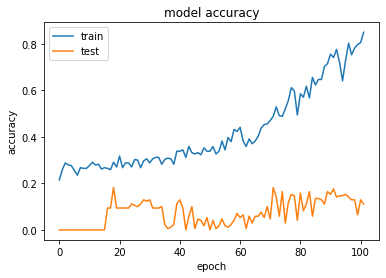

In [377]:
time = datetime.now()
timestampStr = time.strftime("%d %b %Y %H %M %S %f)")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt

<module 'matplotlib.pyplot' from 'c:\\users\\t-gamer\\documents\\git\\projetointeligenciaartificialsistemasugestao\\env\\lib\\site-packages\\matplotlib\\pyplot.py'>

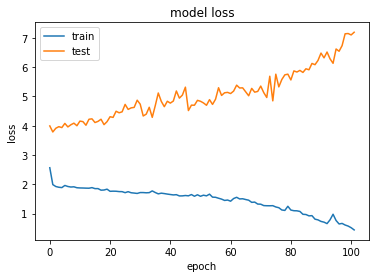

In [378]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("loss"+timestampStr+".png")
plt

In [379]:

def playNote(nota):
    PyAudio = pyaudio.PyAudio     #initialize pyaudio

    #See https://en.wikipedia.org/wiki/Bit_rate#Audio
    BITRATE = 56000     #number of frames per second/frameset.      

    FREQUENCY = nota     #Hz, waves per second, 261.63=C4-note.
    LENGTH = 0.05     #seconds to play sound

    if FREQUENCY > BITRATE:
        BITRATE = FREQUENCY+100

    NUMBEROFFRAMES = int(BITRATE * LENGTH)
    RESTFRAMES = NUMBEROFFRAMES % BITRATE
    WAVEDATA = ''    

    #generating wawes
    for x in range(NUMBEROFFRAMES):
     WAVEDATA = WAVEDATA+chr(int(math.sin(x/((BITRATE/FREQUENCY)/math.pi))*127+128))    

    for x in range(RESTFRAMES): 
     WAVEDATA = WAVEDATA+chr(128)

    p = PyAudio()
    stream = p.open(format = p.get_format_from_width(1), 
                    channels = 1, 
                    rate = BITRATE, 
                    output = True)

    stream.write(WAVEDATA)
    stream.stop_stream()
    stream.close()
    p.terminate()

- Teste

In [380]:

testText = open('predict.txt', 'r', encoding='utf-8').read()

dataTestX = []
seq_in = testText[0: seq_length].lower()

dataTestX.append([char_to_int[char] for char in seq_in])

In [381]:
print(seq_in)

*-/44/+/+*


In [382]:
testX = numpy.reshape(dataTestX, (1, seq_length, 1))

prediction = model.predict(testX, verbose=0)
index = numpy.argmax(prediction)
print(int_to_char[index])

*


In [383]:
resultado = ""
for i in range(100):
    testX = numpy.reshape(dataTestX, (1, seq_length, 1))

    prediction = model.predict(testX, verbose=0)
    index = numpy.argmax(prediction)
    
    resultado += int_to_char[index]
    
    dataTestX[0].pop(0) 
    dataTestX[0].append(index)



In [384]:
resultado
                        

'**+-++(((+-++(((+-++(((+-++(((+-++(((+-++(((+-++(((+-++(((+-++(((+-++(((+-++(((+-++(((+-++(((+-++((('

In [386]:
print(seq_in + resultado)

*-/44/+/+***+-++(((+-++(((+-++(((+-++(((+-++(((+-++(((+-++(((+-++(((+-++(((+-++(((+-++(((+-++(((+-++(((+-++(((


In [387]:
#for x in [char_to_int[char] for char in resultado]:
#    print(int(x))
for char in resultado:
    freq = notas.loc[notas['Número da tecla'] == ord(char)]['Frequência (Hz)'].values[0].replace(",",".")
    playNote(float(freq))